# LLaVA 이미지 분석 리포트 생성
GoodsAD + MVTec-LOCO test 이미지를 LLaVA에 넣어 JSON 리포트 생성

- AD 모델 없이 이미지만 LLaVA에 전달
- splicing_connectors 제외, 총 10개 클래스
- 출력: 카테고리별 JSON 리포트

## 1. 환경 설정

In [ ]:
import os, sys, warnings
warnings.filterwarnings('ignore')

from pathlib import Path

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !pip install -q transformers accelerate sentencepiece bitsandbytes
    PROJECT_ROOT = Path('/content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation')
except ImportError:
    PROJECT_ROOT = Path.cwd().parents[1]

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    

## 2. 경로 설정 & 이미지 수집

In [ ]:
DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"
OUTPUT_DIR = PROJECT_ROOT / "output" / "llava_reports"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_DATASETS = ["GoodsAD", "MVTec-LOCO"]
EXCLUDE_CATEGORIES = {"splicing_connectors"}
EXCLUDE_DIRS = {"split_csv", "visa_pytorch"}

print(f"Data Root: {DATA_ROOT}")
print(f"Output Dir: {OUTPUT_DIR}")

Data Root: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/dataset/MMAD
Output Dir: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/output/llava_reports


In [ ]:
from collections import Counter, defaultdict

def collect_test_images(data_root, dataset):
    ds_path = Path(data_root) / dataset
    if not ds_path.exists():
        print(f"[WARN] 경로 없음: {ds_path}")
        return []

    images = []
    categories = sorted([
        d.name for d in ds_path.iterdir()
        if d.is_dir()
        and not d.name.startswith(".")
        and d.name not in EXCLUDE_DIRS
        and d.name not in EXCLUDE_CATEGORIES
    ])

    for category in categories:
        test_dir = ds_path / category / "test"
        if not test_dir.exists():
            continue
        for defect_dir in sorted(test_dir.iterdir()):
            if not defect_dir.is_dir():
                continue
            for img_path in sorted(defect_dir.iterdir()):
                if img_path.suffix.lower() in (".png", ".jpg", ".jpeg", ".bmp"):
                    images.append({
                        "path": str(img_path),
                        "dataset": dataset,
                        "category": category,
                        "defect_type": defect_dir.name,
                        "filename": img_path.name,
                    })
    return images

# 이미지 수집
all_images = []
for ds in TARGET_DATASETS:
    all_images.extend(collect_test_images(DATA_ROOT, ds))

# 요약
ds_cat_counts = Counter(f"{img['dataset']}/{img['category']}" for img in all_images)
print(f"\n총 {len(all_images)}개 이미지 ({len(ds_cat_counts)}개 카테고리)")
for key, count in sorted(ds_cat_counts.items()):
    print(f"  {key}: {count}장")


총 4243개 이미지 (10개 카테고리)
  GoodsAD/cigarette_box: 429장
  GoodsAD/drink_bottle: 781장
  GoodsAD/drink_can: 293장
  GoodsAD/food_bottle: 604장
  GoodsAD/food_box: 397장
  GoodsAD/food_package: 483장
  MVTec-LOCO/breakfast_box: 275장
  MVTec-LOCO/juice_bottle: 330장
  MVTec-LOCO/pushpins: 310장
  MVTec-LOCO/screw_bag: 341장


## 3. LLaVA 모델 로드

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

LLAVA_MODEL = "llava-hf/llava-1.5-7b-hf"  # 13b: llava-hf/llava-1.5-13b-hf

print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Loading: {LLAVA_MODEL}")

model = LlavaForConditionalGeneration.from_pretrained(
    LLAVA_MODEL,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(LLAVA_MODEL)

print("로딩 완료")

GPU: NVIDIA A100-SXM4-40GB
Loading: llava-hf/llava-1.5-7b-hf


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

로딩 완료


## 4. 리포트 생성 함수 정의

In [15]:
import json, re, time
from datetime import datetime
from PIL import Image

REPORT_PROMPT = '''You are an expert industrial quality inspector.
Look at this product image carefully and determine if there are any defects or anomalies.
Pay close attention to: surface damage, deformation, missing parts, wrong positioning,
opened packaging, contamination, cracks, scratches, or any other abnormality.

Product category: {category}

If the product looks perfect and normal, set "has_defect" to false.
If there is ANY abnormality, set "has_defect" to true.

Respond in JSON format ONLY:
{{
  "product_info": {{
    "category": "{category}",
    "description": "brief product appearance description"
  }},
  "anomaly_info": {{
    "has_defect": true or false,
    "defect_type": "type of defect or none",
    "location": "where the defect is or none",
    "severity": "low or medium or high or none",
    "description": "detailed defect description or normal",
    "possible_cause": "estimated cause or none"
  }},
  "decision": "normal or anomaly",
  "confidence": 0.0 to 1.0,
  "summary": "one sentence inspection summary",
  "impact": "impact analysis",
  "recommendation": "action recommendation"
}}
'''


def generate_report(image_info):
    """단일 이미지 → LLaVA → JSON 리포트"""
    prompt_text = REPORT_PROMPT.format(category=image_info["category"])
    user_prompt = f"USER: <image>\n{prompt_text}\nASSISTANT:"

    img = Image.open(image_info["path"]).convert("RGB")

    inputs = processor(text=user_prompt, images=[img], return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    t0 = time.time()
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=512,
            do_sample=False,
            repetition_penalty=1.2,
        )
    inference_time = round(time.time() - t0, 2)

    response = processor.decode(output[0], skip_special_tokens=True)
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1].strip()

    # LLaVA가 \_를 출력하는 문제 수정
    cleaned = response.replace("\\_", "_")

    # JSON 파싱
    json_match = re.search(r'\{[\s\S]*\}', cleaned)
    parsed = None
    if json_match:
        try:
            parsed = json.loads(json_match.group())
        except json.JSONDecodeError:
            pass

    if parsed is None:
        parsed = {"raw_response": response}

    report = {
        "filename": image_info["filename"],
        "image_path": image_info["path"],
        "dataset": image_info["dataset"],
        "category": image_info["category"],
        "ground_truth": image_info["defect_type"],
        "datetime": datetime.utcnow().isoformat(),
        "inference_time": inference_time,
        **parsed,
    }

    # decision 정규화: "정상" → "normal" 등
    dec = str(report.get("decision", "")).strip().lower()
    if dec in ("정상", "good", "ok"):
        report["decision"] = "normal"
    elif dec in ("이상", "불량", "defect", "bad", "abnormal"):
        report["decision"] = "anomaly"

    return report

print("함수 정의 완료")

함수 정의 완료


## 5. 샘플 테스트 (1장)

테스트: GoodsAD/cigarette_box/good/000_001.jpg


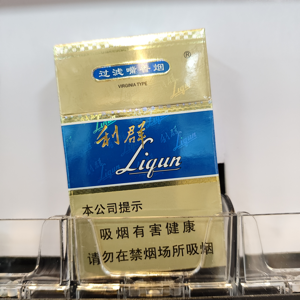

{
  "filename": "000_001.jpg",
  "image_path": "/content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/dataset/MMAD/GoodsAD/cigarette_box/test/good/000_001.jpg",
  "dataset": "GoodsAD",
  "category": "cigarette_box",
  "ground_truth": "good",
  "datetime": "2026-02-04T08:28:45.965134",
  "inference_time": 6.37,
  "product_info": {
    "category": "cigarette_box",
    "description": "A box of Ligun cigarettes."
  },
  "anomaly_info": {
    "has_defect": false,
    "defect_type": "",
    "location": "",
    "severity": "",
    "description": "The box appears to be new and unused.",
    "possible_cause": ""
  },
  "decision": "normal",
  "confidence": 1.0,
  "summary": "The box of Ligun cigarettes appears to be undamaged and free from any visible defects.",
  "impact": "No impact on decision as all aspects appear normal.",
  "recommendation": "Acceptance without further investigation."
}


In [16]:
# 첫 번째 이미지로 테스트
sample = all_images[0]
print(f"테스트: {sample['dataset']}/{sample['category']}/{sample['defect_type']}/{sample['filename']}")

# 이미지 확인
from IPython.display import display
img = Image.open(sample["path"]).convert("RGB")
img_resized = img.resize((300, 300))
display(img_resized)

# 리포트 생성
test_report = generate_report(sample)
print(json.dumps(test_report, ensure_ascii=False, indent=2))

## 5-1. 카테고리당 1장씩 10장 샘플 테스트

샘플 10장 선택:
  GoodsAD/cigarette_box/opened/037_005.jpg
  GoodsAD/drink_bottle/cap_open/037_010.jpg
  GoodsAD/drink_can/deformation/042_006.jpg
  GoodsAD/food_bottle/good/044_016.jpg
  GoodsAD/food_box/good/024_009.jpg
  GoodsAD/food_package/good/010_008.jpg
  MVTec-LOCO/breakfast_box/good/071.png
  MVTec-LOCO/juice_bottle/good/052.png
  MVTec-LOCO/pushpins/structural_anomalies/050.png
  MVTec-LOCO/screw_bag/good/044.png

[1/10] GoodsAD/cigarette_box - 037_005.jpg (GT: opened)


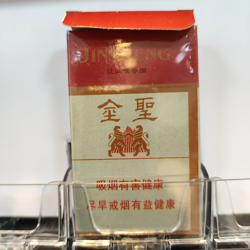

  Decision: normal (confidence: 1.0)
  Inference: 5.97s
  Defect: False |  | 
  Description: The box appears to be new and unused.
  Summary: No visible defects on the Jinling brand cigarette box.

[2/10] GoodsAD/drink_bottle - 037_010.jpg (GT: cap_open)


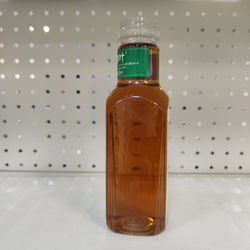

  Decision: normal (confidence: 1.0)
  Inference: 5.68s
  Defect: False |  | 
  Description: The bottle appears to be unblemished.
  Summary: The bottle has no visible defects.

[3/10] GoodsAD/drink_can - 042_006.jpg (GT: deformation)


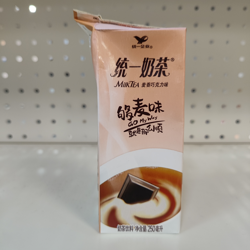

  Decision: normal (confidence: 1.0)
  Inference: 5.53s
  Defect: False |  | 
  Description: The package appears undisturbed.
  Summary: No visible defects on the box or its contents.

[4/10] GoodsAD/food_bottle - 044_016.jpg (GT: good)


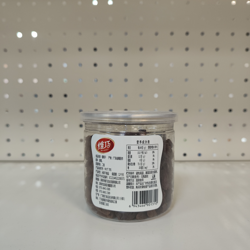

  Decision: normal (confidence: 1.0)
  Inference: 5.88s
  Defect: False |  | 
  Description: The container appears clean and undamaged.
  Summary: The jar has no visible defects or issues.

[5/10] GoodsAD/food_box - 024_009.jpg (GT: good)


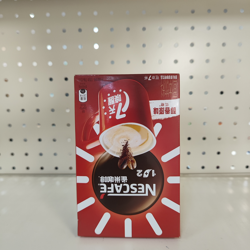

  Decision: normal (confidence: 1.0)
  Inference: 5.76s
  Defect: False |  | 
  Description: The box appears to be undisturbed.
  Summary: No visible defects on the box or its contents.

[6/10] GoodsAD/food_package - 010_008.jpg (GT: good)


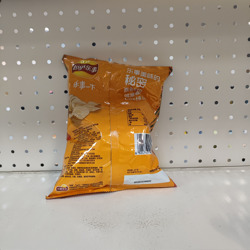

  Decision: normal (confidence: 1.0)
  Inference: 5.93s
  Defect: False |  | 
  Description: The package appears to be untouched.
  Summary: No visible defects or irregularities.

[7/10] MVTec-LOCO/breakfast_box - 071.png (GT: good)


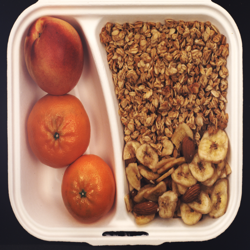

  Decision: normal (confidence: 1.0)
  Inference: 6.69s
  Defect: False |  | 
  Description: The food items appear fresh and unblemished.
  Summary: All food items look fresh and undamaged.

[8/10] MVTec-LOCO/juice_bottle - 052.png (GT: good)


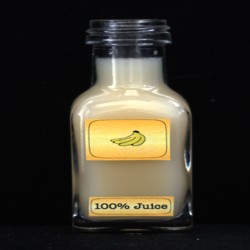

  Decision: normal (confidence: 1.0)
  Inference: 6.06s
  Defect: False |  | 
  Description: The bottle appears to be unblemished.
  Summary: No visible defects or irregularities.

[9/10] MVTec-LOCO/pushpins - 050.png (GT: structural_anomalies)


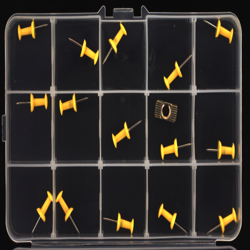

  Decision: normal (confidence: 1.0)
  Inference: 5.58s
  Defect: False |  | 
  Description: All items appear to be intact.
  Summary: The container appears to have no issues or defects.

[10/10] MVTec-LOCO/screw_bag - 044.png (GT: good)


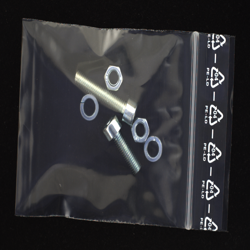

  Decision: normal (confidence: 1.0)
  Inference: 5.77s
  Defect: False |  | 
  Description: All components appear to be intact.
  Summary: The screw bag appears to be undamaged with all its contents properly arranged.

샘플 결과 저장: /content/drive/Othercomputers/mynotebook/multimodal-anomaly-report-generation/output/llava_reports/sample_10_reports.json
샘플 정확도: 6/10 (60%)


In [17]:
import random
from IPython.display import display

# 카테고리당 1장씩 샘플링 (총 10장)
random.seed(42)
by_category = defaultdict(list)
for img in all_images:
    key = f"{img['dataset']}/{img['category']}"
    by_category[key].append(img)

sample_10 = []
for key in sorted(by_category.keys()):
    sample_10.append(random.choice(by_category[key]))

print(f"샘플 {len(sample_10)}장 선택:")
for s in sample_10:
    print(f"  {s['dataset']}/{s['category']}/{s['defect_type']}/{s['filename']}")

# 리포트 생성
sample_results = []
for i, img_info in enumerate(sample_10, 1):
    label = f"{img_info['dataset']}/{img_info['category']}"
    print(f"\n[{i}/{len(sample_10)}] {label} - {img_info['filename']} (GT: {img_info['defect_type']})")

    img = Image.open(img_info["path"]).convert("RGB")
    display(img.resize((250, 250)))

    report = generate_report(img_info)
    sample_results.append(report)

    print(f"  Decision: {report.get('decision', '?')} (confidence: {report.get('confidence', '?')})")
    print(f"  Inference: {report.get('inference_time', '?')}s")
    if isinstance(report.get("anomaly_info"), dict):
        ai = report["anomaly_info"]
        print(f"  Defect: {ai.get('has_defect', '?')} | {ai.get('defect_type', '')} | {ai.get('severity', '')}")
        print(f"  Description: {ai.get('description', '')}")
    print(f"  Summary: {report.get('summary', '')}")

# 샘플 결과 저장
sample_path = OUTPUT_DIR / "sample_10_reports.json"
with open(sample_path, "w", encoding="utf-8") as f:
    json.dump(sample_results, f, ensure_ascii=False, indent=2)
print(f"\n샘플 결과 저장: {sample_path}")

# 간단 정확도
correct = sum(
    1 for r in sample_results
    if (r["ground_truth"] == "good" and r.get("decision") == "normal")
    or (r["ground_truth"] != "good" and r.get("decision") == "anomaly")
)
print(f"샘플 정확도: {correct}/{len(sample_results)} ({correct/len(sample_results)*100:.0f}%)")

## 6. 전체 배치 실행

In [ ]:
from tqdm.notebook import tqdm

results = []
errors = []

for img_info in tqdm(all_images, desc="LLaVA 리포트 생성"):
    try:
        report = generate_report(img_info)
        results.append(report)
    except Exception as e:
        errors.append({
            "filename": img_info["filename"],
            "dataset": img_info["dataset"],
            "category": img_info["category"],
            "error": str(e),
        })

print(f"\n완료: 성공 {len(results)}개, 실패 {len(errors)}개")

LLaVA 리포트 생성:   0%|          | 0/4243 [00:00<?, ?it/s]

## 7. 결과 저장

In [ ]:
# 전체 결과 저장
all_path = OUTPUT_DIR / "all_reports.json"
with open(all_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print(f"전체 결과: {all_path}")

# 카테고리별 저장
by_cat = defaultdict(list)
for r in results:
    key = f"{r['dataset']}_{r['category']}"
    by_cat[key].append(r)

for key, reports in sorted(by_cat.items()):
    cat_dir = OUTPUT_DIR / key
    cat_dir.mkdir(parents=True, exist_ok=True)
    cat_path = cat_dir / "reports.json"
    with open(cat_path, "w", encoding="utf-8") as f:
        json.dump(reports, f, ensure_ascii=False, indent=2)
    print(f"  {key}: {len(reports)}개 → {cat_path}")

# 에러 저장
if errors:
    err_path = OUTPUT_DIR / "errors.json"
    with open(err_path, "w", encoding="utf-8") as f:
        json.dump(errors, f, ensure_ascii=False, indent=2)
    print(f"\n에러: {err_path}")

## 8. 결과 분석

In [ ]:
import pandas as pd

df = pd.DataFrame(results)

# ground_truth가 'good'이면 정상, 아니면 이상
df["gt_label"] = df["ground_truth"].apply(lambda x: "normal" if x == "good" else "anomaly")

# LLaVA 판정
df["llava_decision"] = df["decision"].fillna("unknown")

# 일치 여부
df["correct"] = df["gt_label"] == df["llava_decision"]

print("=== 카테고리별 정확도 ===")
acc_by_cat = df.groupby(["dataset", "category"]).agg(
    total=("correct", "count"),
    correct=("correct", "sum"),
).reset_index()
acc_by_cat["accuracy"] = (acc_by_cat["correct"] / acc_by_cat["total"]).round(4)
print(acc_by_cat.to_string(index=False))

print(f"\n전체 정확도: {df['correct'].mean():.4f}")
print(f"평균 추론 시간: {df['inference_time'].mean():.2f}s")

In [ ]:
# 혼동 행렬
print("=== 전체 혼동 행렬 ===")
print(pd.crosstab(df["gt_label"], df["llava_decision"], margins=True))

print("\n=== 카테고리별 혼동 행렬 ===")
for (ds, cat), group in df.groupby(["dataset", "category"]):
    print(f"\n{ds}/{cat} ({len(group)}장)")
    print(pd.crosstab(group["gt_label"], group["llava_decision"]))

In [ ]:
# 리포트 샘플 확인
for (ds, cat), group in df.groupby(["dataset", "category"]):
    sample = group.iloc[0]
    print(f"\n{'='*60}")
    print(f"{ds}/{cat} - {sample['filename']} (GT: {sample['gt_label']})")
    print(f"{'='*60}")

    # 이미지 표시
    img = Image.open(sample["image_path"]).convert("RGB").resize((200, 200))
    display(img)

    print(f"  Decision: {sample.get('llava_decision', '?')}")
    if isinstance(sample.get('product_info'), dict):
        print(f"  Product: {sample['product_info']}")
    if isinstance(sample.get('anomaly_info'), dict):
        print(f"  Anomaly: {sample['anomaly_info']}")
    print(f"  Summary: {sample.get('summary', '')}")